# Logging metrics with LivelossplotLogger inside Jupyter Notebook/Lab

In this notebook we will show how to use `LivelossplotLogger` to interactively plot training/validation metrics
inside Jupyter Notebook or Lab. We will use MNIST dataset.

To run this example, we need to have installed `matplotlib` and `livelossplot`.

In [1]:
!pip install matplotlib livelossplot --quiet

%matplotlib inline

## Setup model, optimizer, criterion etc

Let's define basic training ingredients:
- dataloaders
- model
- optimizer
- criterion

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


def get_data_loaders(train_batch_size, val_batch_size):
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    train_loader = DataLoader(
        MNIST(download=True, root=".", transform=data_transform, train=True), batch_size=train_batch_size, shuffle=True
    )

    val_loader = DataLoader(
        MNIST(download=False, root=".", transform=data_transform, train=False), batch_size=val_batch_size, shuffle=False
    )
    return train_loader, val_loader

In [3]:
train_loader, val_loader = get_data_loaders(train_batch_size=256, val_batch_size=1000)

model = Net()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

model.to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

## Setup training components 

Let's setup training and evaluation engines

In [4]:
from ignite.contrib.handlers.livelossplot_logger import *
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.utils import setup_logger


trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
trainer.logger = setup_logger("Trainer")
metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
train_evaluator.logger = setup_logger("Train Evaluator")
validation_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
validation_evaluator.logger = setup_logger("Val Evaluator")


@trainer.on(Events.EPOCH_COMPLETED)
def compute_metrics(engine):
    train_evaluator.run(train_loader)
    validation_evaluator.run(val_loader)



Now, let's setup `LivelossplotLogger`. This class follows the same API as other loggers, e.g. `TensorboardLogger`.

In [5]:
# in order to skip external dependencies in ignite
from livelossplot.outputs import MatplotlibPlot

livelossplot_logger = LivelossplotLogger()

livelossplot_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED(every=10),
    tag="online",
    output_transform=lambda loss: {"batch loss": loss},
)

for tag, evaluator in [("training", train_evaluator), ("validation", validation_evaluator)]:
    livelossplot_logger.attach_output_handler(
        evaluator,
        event_name=Events.EPOCH_COMPLETED,
        tag=tag,
        metric_names=["loss", "accuracy"],
        global_step_transform=global_step_from_engine(trainer),
    )

livelossplot_logger.attach_opt_params_handler(
    trainer, event_name=Events.ITERATION_COMPLETED(every=10), optimizer=optimizer
)

Let's start the training

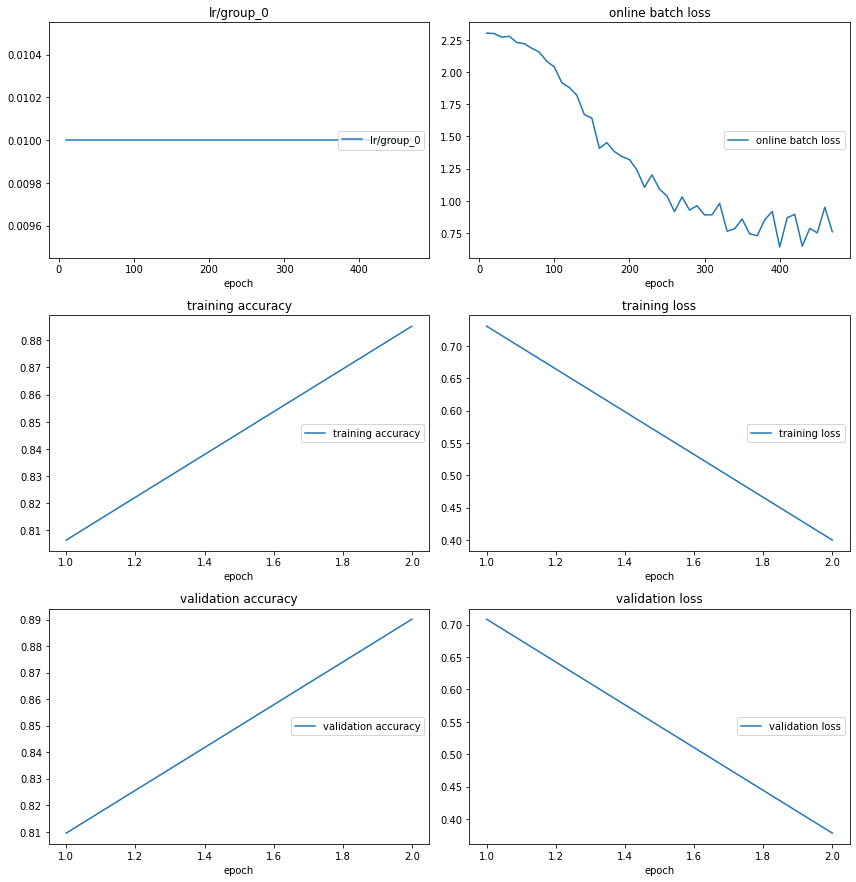

2020-07-01 11:15:15,462 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-07-01 11:15:15,463 Val Evaluator INFO: Engine run complete. Time taken: 00:00:02
2020-07-01 11:15:15,464 Trainer INFO: Epoch[2] Complete. Time taken: 00:00:55
2020-07-01 11:15:15,465 Trainer INFO: Engine run complete. Time taken: 00:01:41


State:
	iteration: 470
	epoch: 2
	epoch_length: 235
	max_epochs: 2
	output: 0.758751630783081
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [6]:
trainer.run(train_loader, max_epochs=2)